In [1]:
# !nvidia-smi
# !pip install prefetch_generator
# !pip install timm
# !pip install albumentations

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange
import torchvision
import boto3
import io
import sagemaker
from sagemaker import get_execution_role
import tempfile
import PIL
import time
from datetime import timedelta
from prefetch_generator import BackgroundGenerator
import timm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn import model_selection, metrics

In [3]:
# Make sure you're using cuda (GPU) by checking the hardware accelerator under Runtime -> Change runtime type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cuda


# Download dataset from AWS S3

In [4]:
dataset_name = "Dataset"
if not os.path.exists(dataset_name):
    !pip install cloudpathlib[s3,gs,azure]
    from cloudpathlib import CloudPath
    cp = CloudPath("s3://cassavaproject")
    cp.download_to("./" + dataset_name)
else:
    print(f"File exists: {dataset_name}")

File exists: Dataset


# Preprocessing

In [5]:
class MyDataset(Dataset):

    def __init__(self, df, transform=None):
        self.image_path = 'Dataset/train_images'
        self.labels = df
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_path + '/' + self.labels.iloc[idx]['image_id']

        # Read the image from the file path
        #image = Image.open(img_name)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = torchvision.io.read_file(img_name)
        #image = torchvision.io.decode_jpeg(image, device="cpu")
        #image = image.float().
        
        # Transform the image using self.transform
        if self.transform:
            image = self.transform(image=image)["image"]

        if "label" in self.labels.columns:
            label = self.labels.iloc[idx]['label']
            sample = (image, label)
        else:
            sample = (image)
        return sample

In [6]:
#Used for directly download and read file from AWS S3.
#If running the download cell above, use 'MyDataset' class instead of this one.
class MyDatasetS3(Dataset):

    def __init__(self, df, transform=None):
        #File path for csv and images
        self.image_path = 'train_images'
        
        #Connect to s3 file
        self.csv_path = df
        self.s3_client = boto3.resource('s3')
        self.bucket = self.s3_client.Bucket('cassavaproject')
        
        s3 = boto3.client('s3')
        obj = s3.get_object(Bucket = 'cassavaproject',Key = 'train.csv')

        self.labels = pd.read_csv(obj['Body'])
        
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.image_path + '/' + self.labels.iloc[idx]['image_id']
        
        # we can download the file from S3 to a temporary file locally, then store that opened file as our image variable.
        # we need to create the local file name
        obj = self.bucket.Object(img_name)
        tmp = tempfile.NamedTemporaryFile()
        tmp_name = '{}.jpg'.format(tmp.name)

        # now we can actually download from S3 to a local place
        with open(tmp_name, 'wb') as f:
            obj.download_fileobj(f)
            f.flush()
            f.close()
            
            image = torchvision.io.read_file(tmp_name)
            image = torchvision.io.decode_jpeg(image, device="cpu")
            image = image.float()
            
        # Transform the image using self.transform
        if self.transform:
            image = self.transform(image=image)["image"]

        if "label" in self.labels.columns:
            label = self.labels.iloc[idx]['label']
            sample = (image, label)
        else:
            sample = (image)
        return sample

In [7]:
# Credit: https://www.kaggle.com/code/aliabdin1/calculate-mean-std-of-images/notebook
mean = np.array([0.42984136, 0.49624753, 0.3129598 ])
std = np.array([0.21417203, 0.21910103, 0.19542212])

In [8]:
train_transform = torch.nn.Sequential(transforms.Resize((256,256),antialias=True), 
                                      transforms.Normalize(mean=mean,std=std))

In [9]:
albu_transform_train = A.Compose(
        [A.CenterCrop(height=256, width=256), 
         A.HorizontalFlip(p=0.5),
         A.VerticalFlip(p=0.5),
         A.RandomRotate90(p=0.5),
         A.RandomBrightnessContrast(p=0.8), 
         A.CoarseDropout(p=0.5),
         A.Normalize(mean=mean, std=std),
         ToTensorV2()
        ])

In [10]:
albu_transform_test = A.Compose(
        [A.CenterCrop(height=256, width=256),
         A.Normalize(mean=mean, std=std),
         ToTensorV2()
        ])

In [11]:
df = pd.read_csv('Dataset/train.csv')

train_df, test_df = model_selection.train_test_split(
    df, test_size=0.3, random_state=42, stratify=df.label.values
)

train_data = MyDataset(train_df, transform = albu_transform_train)
test_data = MyDataset(test_df, transform = albu_transform_test)

# Define our model

In [12]:
# timm.list_models('*resnet*')

In [13]:
test_model = timm.create_model('resnet50d', pretrained=True)
test_model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1.0',
 'classifier': 'fc',
 'architecture': 'resnet50d'}

In [14]:
class OurModel(nn.Module):
    def __init__(self, num_classes):
        super(OurModel, self).__init__()
        self.model = timm.create_model('resnet50d', pretrained=True) #torchvision.models.resnet34(weights='IMAGENET1K_V1')
        self.drop = nn.Dropout(p=0.2)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax()
    def forward(self, input):
        out = self.model(input)
        out = self.drop(out)
        softmax = self.softmax(out)
        return softmax

# Train our model

In [15]:
model = OurModel(5).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=2e-5, weight_decay=1e-6, 
                             amsgrad=False) #torch.optim.Adam(model.parameters(), lr=5*1e-3)


In [16]:
class DataLoaderX(DataLoader):

    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

In [17]:
train_loader = DataLoaderX(dataset=train_data, batch_size = 64, shuffle= True, num_workers=2, pin_memory=True)
test_loader = DataLoaderX(dataset=test_data, batch_size = 64, shuffle=False, num_workers=2, pin_memory=True)

In [18]:
print('Start fine-tuning...')

Start fine-tuning...


In [19]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)

            _,prediction = torch.max(outputs.data, 1)
            correct += (prediction == labels).sum().item()
            total += labels.size(0)
        model.train()
        return 100 * correct / total

In [20]:
def get_run_time(start_time):
    end_time = time.time()
    runtime = end_time - start_time
    return runtime

In [21]:
best_acc = 0.
best_epoch = None
end_patient = 0
num_epochs = 50
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True)

save_model_path = ''
train_loss = []
train_accuracy = []
test_accuracy = []

start_time = time.time()


for epoch in trange(num_epochs):
    correct = 0
    total = 0
    epoch_loss = 0.
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss
        _, prediction = torch.max(outputs.data, 1)
        correct += (prediction == labels).sum().item()
        total += labels.size(0)

        time_diff = get_run_time(start_time)

        # print('Epoch [{}/{}]: Iter {}, Loss {:.4f}, Runtime {:.0f}m {:.0f}s'.format(epoch + 1, num_epochs, i + 1, loss, time_diff//60, time_diff%60))
        train_loss.append(loss)

    train_acc = 100 * correct / total
    print('Testing on test dataset...')
    test_acc = test_model(model, test_loader)
    print('Epoch [{}/{}] Loss: {:.4f} Train_Acc: {:.4f}  Test_Acc: {:.4f}'
          .format(epoch + 1, num_epochs, epoch_loss, train_acc, test_acc))
    scheduler.step(test_acc)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    if (test_acc > best_acc) & (test_acc >82):
        best_acc = test_acc
        best_epoch = epoch + 1
        print('The accuracy is improved, save model')
        torch.save(model.state_dict(), os.path.join(
                                                    'resnet50_acc_%g.pth' %
                                                    (best_acc)))

print('After the training, the end of the epoch %d, the accuracy %g is the highest' % (best_epoch, best_acc))

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_19462/3367771019.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = self.softmax(out)


Testing on test dataset...


  2%|▏         | 1/50 [02:31<2:03:35, 151.34s/it]

Epoch [1/50] Loss: 329.0652 Train_Acc: 55.8723  Test_Acc: 66.2617
Testing on test dataset...


  4%|▍         | 2/50 [05:00<2:00:06, 150.15s/it]

Epoch [2/50] Loss: 299.5453 Train_Acc: 61.2873  Test_Acc: 69.0498
Testing on test dataset...


  6%|▌         | 3/50 [07:27<1:56:16, 148.44s/it]

Epoch [3/50] Loss: 290.0157 Train_Acc: 64.0515  Test_Acc: 72.7726
Testing on test dataset...


  8%|▊         | 4/50 [09:52<1:52:59, 147.37s/it]

Epoch [4/50] Loss: 285.7605 Train_Acc: 66.3417  Test_Acc: 74.8598
Testing on test dataset...


 10%|█         | 5/50 [12:20<1:50:32, 147.38s/it]

Epoch [5/50] Loss: 277.9972 Train_Acc: 70.0875  Test_Acc: 79.8598
Testing on test dataset...


 12%|█▏        | 6/50 [14:48<1:48:24, 147.83s/it]

Epoch [6/50] Loss: 269.7361 Train_Acc: 73.1922  Test_Acc: 80.7477
Testing on test dataset...


 14%|█▍        | 7/50 [17:13<1:45:10, 146.75s/it]

Epoch [7/50] Loss: 267.4847 Train_Acc: 74.2672  Test_Acc: 81.6511
Testing on test dataset...


 16%|█▌        | 8/50 [19:38<1:42:24, 146.31s/it]

Epoch [8/50] Loss: 264.7632 Train_Acc: 75.7829  Test_Acc: 82.0717
The accuracy is improved, save model
Testing on test dataset...


 18%|█▊        | 9/50 [22:09<1:40:56, 147.73s/it]

Epoch [9/50] Loss: 261.3680 Train_Acc: 77.0114  Test_Acc: 81.6355
Testing on test dataset...


 20%|██        | 10/50 [24:36<1:38:22, 147.57s/it]

Epoch [10/50] Loss: 260.7094 Train_Acc: 77.2050  Test_Acc: 83.6604
The accuracy is improved, save model
Testing on test dataset...


 22%|██▏       | 11/50 [27:02<1:35:31, 146.97s/it]

Epoch [11/50] Loss: 258.5465 Train_Acc: 77.7526  Test_Acc: 83.8318
The accuracy is improved, save model
Testing on test dataset...


 24%|██▍       | 12/50 [29:28<1:32:50, 146.59s/it]

Epoch [12/50] Loss: 256.8381 Train_Acc: 78.8676  Test_Acc: 84.0031
The accuracy is improved, save model
Testing on test dataset...


 26%|██▌       | 13/50 [31:57<1:30:51, 147.33s/it]

Epoch [13/50] Loss: 256.8523 Train_Acc: 78.3602  Test_Acc: 84.2523
The accuracy is improved, save model
Testing on test dataset...


 28%|██▊       | 14/50 [34:27<1:28:55, 148.21s/it]

Epoch [14/50] Loss: 255.6031 Train_Acc: 79.0212  Test_Acc: 83.5514
Testing on test dataset...


 30%|███       | 15/50 [36:41<1:23:53, 143.82s/it]

Epoch [15/50] Loss: 255.1485 Train_Acc: 79.3083  Test_Acc: 84.2523
Testing on test dataset...


 32%|███▏      | 16/50 [38:09<1:12:06, 127.24s/it]

Epoch [16/50] Loss: 255.1844 Train_Acc: 79.6354  Test_Acc: 84.0187
Testing on test dataset...


 34%|███▍      | 17/50 [40:35<1:12:58, 132.68s/it]

Epoch [17/50] Loss: 254.0228 Train_Acc: 80.1829  Test_Acc: 84.3302
The accuracy is improved, save model
Testing on test dataset...


 36%|███▌      | 18/50 [43:01<1:12:54, 136.71s/it]

Epoch [18/50] Loss: 253.9791 Train_Acc: 79.9760  Test_Acc: 84.5950
The accuracy is improved, save model
Testing on test dataset...


 38%|███▊      | 19/50 [45:25<1:11:52, 139.11s/it]

Epoch [19/50] Loss: 252.9793 Train_Acc: 80.4968  Test_Acc: 84.5171
Testing on test dataset...


 40%|████      | 20/50 [47:50<1:10:24, 140.81s/it]

Epoch [20/50] Loss: 253.1253 Train_Acc: 80.1095  Test_Acc: 83.8941
Testing on test dataset...


 42%|████▏     | 21/50 [50:19<1:09:10, 143.11s/it]

Epoch [21/50] Loss: 251.8092 Train_Acc: 81.2245  Test_Acc: 84.9221
The accuracy is improved, save model
Testing on test dataset...


 44%|████▍     | 22/50 [52:43<1:06:59, 143.54s/it]

Epoch [22/50] Loss: 250.1227 Train_Acc: 81.3581  Test_Acc: 84.3302
Testing on test dataset...


 46%|████▌     | 23/50 [55:12<1:05:18, 145.14s/it]

Epoch [23/50] Loss: 251.2657 Train_Acc: 81.0109  Test_Acc: 84.8287
Testing on test dataset...


 48%|████▊     | 24/50 [57:35<1:02:32, 144.32s/it]

Epoch [24/50] Loss: 249.9544 Train_Acc: 81.8321  Test_Acc: 84.5016
Testing on test dataset...


 50%|█████     | 25/50 [1:00:03<1:00:38, 145.56s/it]

Epoch [25/50] Loss: 249.9315 Train_Acc: 81.7654  Test_Acc: 84.5483
Epoch 00025: reducing learning rate of group 0 to 4.0000e-06.
Testing on test dataset...


 52%|█████▏    | 26/50 [1:02:30<58:25, 146.08s/it]  

Epoch [26/50] Loss: 247.9182 Train_Acc: 82.2194  Test_Acc: 84.4081
Testing on test dataset...


 54%|█████▍    | 27/50 [1:04:55<55:53, 145.80s/it]

Epoch [27/50] Loss: 247.6968 Train_Acc: 82.4197  Test_Acc: 84.4393
Testing on test dataset...


 56%|█████▌    | 28/50 [1:07:23<53:39, 146.36s/it]

Epoch [28/50] Loss: 247.0639 Train_Acc: 82.6868  Test_Acc: 84.8131
Testing on test dataset...


 58%|█████▊    | 29/50 [1:09:51<51:23, 146.83s/it]

Epoch [29/50] Loss: 248.3593 Train_Acc: 82.5933  Test_Acc: 85.0623
The accuracy is improved, save model
Testing on test dataset...


 60%|██████    | 30/50 [1:12:18<48:54, 146.75s/it]

Epoch [30/50] Loss: 246.7599 Train_Acc: 82.7135  Test_Acc: 84.5950
Testing on test dataset...


 62%|██████▏   | 31/50 [1:14:46<46:39, 147.32s/it]

Epoch [31/50] Loss: 247.4571 Train_Acc: 82.2795  Test_Acc: 84.9688
Testing on test dataset...


 64%|██████▍   | 32/50 [1:17:11<43:56, 146.49s/it]

Epoch [32/50] Loss: 246.9542 Train_Acc: 82.9539  Test_Acc: 84.0810
Testing on test dataset...


 66%|██████▌   | 33/50 [1:19:42<41:56, 148.04s/it]

Epoch [33/50] Loss: 246.2388 Train_Acc: 83.2076  Test_Acc: 83.8474
Epoch 00033: reducing learning rate of group 0 to 8.0000e-07.
Testing on test dataset...


 68%|██████▊   | 34/50 [1:22:10<39:26, 147.89s/it]

Epoch [34/50] Loss: 247.1689 Train_Acc: 82.7602  Test_Acc: 84.2679
Testing on test dataset...


 70%|███████   | 35/50 [1:24:34<36:42, 146.86s/it]

Epoch [35/50] Loss: 246.9190 Train_Acc: 82.5332  Test_Acc: 84.8131
Testing on test dataset...


 72%|███████▏  | 36/50 [1:27:00<34:11, 146.54s/it]

Epoch [36/50] Loss: 246.1404 Train_Acc: 82.9872  Test_Acc: 84.5794
Testing on test dataset...


 74%|███████▍  | 37/50 [1:29:26<31:43, 146.41s/it]

Epoch [37/50] Loss: 246.9661 Train_Acc: 82.4932  Test_Acc: 83.5826
Epoch 00037: reducing learning rate of group 0 to 1.6000e-07.
Testing on test dataset...


 76%|███████▌  | 38/50 [1:31:56<29:29, 147.48s/it]

Epoch [38/50] Loss: 247.3352 Train_Acc: 83.3011  Test_Acc: 84.5327
Testing on test dataset...


 78%|███████▊  | 39/50 [1:34:23<26:59, 147.26s/it]

Epoch [39/50] Loss: 246.4770 Train_Acc: 82.8470  Test_Acc: 84.2679
Testing on test dataset...


 80%|████████  | 40/50 [1:36:48<24:24, 146.46s/it]

Epoch [40/50] Loss: 246.4617 Train_Acc: 82.7869  Test_Acc: 85.0000
Testing on test dataset...


 82%|████████▏ | 41/50 [1:39:15<22:01, 146.81s/it]

Epoch [41/50] Loss: 245.6595 Train_Acc: 83.3344  Test_Acc: 84.6729
Epoch 00041: reducing learning rate of group 0 to 3.2000e-08.
Testing on test dataset...


 84%|████████▍ | 42/50 [1:41:45<19:40, 147.55s/it]

Epoch [42/50] Loss: 247.3571 Train_Acc: 82.7936  Test_Acc: 84.8442
Testing on test dataset...


 86%|████████▌ | 43/50 [1:44:12<17:11, 147.37s/it]

Epoch [43/50] Loss: 246.5090 Train_Acc: 82.7001  Test_Acc: 84.7664
Testing on test dataset...


 88%|████████▊ | 44/50 [1:46:38<14:43, 147.21s/it]

Epoch [44/50] Loss: 247.3490 Train_Acc: 82.9539  Test_Acc: 85.2181
The accuracy is improved, save model
Testing on test dataset...


 90%|█████████ | 45/50 [1:49:05<12:15, 147.15s/it]

Epoch [45/50] Loss: 247.2798 Train_Acc: 82.6534  Test_Acc: 84.8287
Testing on test dataset...


 92%|█████████▏| 46/50 [1:51:31<09:46, 146.66s/it]

Epoch [46/50] Loss: 246.2055 Train_Acc: 82.7869  Test_Acc: 84.7664
Testing on test dataset...


 94%|█████████▍| 47/50 [1:53:58<07:20, 146.69s/it]

Epoch [47/50] Loss: 246.0213 Train_Acc: 83.2677  Test_Acc: 84.1433
Testing on test dataset...


 96%|█████████▌| 48/50 [1:56:23<04:52, 146.31s/it]

Epoch [48/50] Loss: 247.2856 Train_Acc: 83.0807  Test_Acc: 84.7196
Epoch 00048: reducing learning rate of group 0 to 6.4000e-09.
Testing on test dataset...


 98%|█████████▊| 49/50 [1:58:51<02:26, 146.75s/it]

Epoch [49/50] Loss: 247.2407 Train_Acc: 82.8604  Test_Acc: 84.4548
Testing on test dataset...


100%|██████████| 50/50 [2:01:15<00:00, 145.51s/it]

Epoch [50/50] Loss: 246.2002 Train_Acc: 83.1675  Test_Acc: 84.9065
After the training, the end of the epoch 44, the accuracy 85.2181 is the highest


# Result Analysis

In [22]:
import matplotlib.pyplot as plt
import itertools

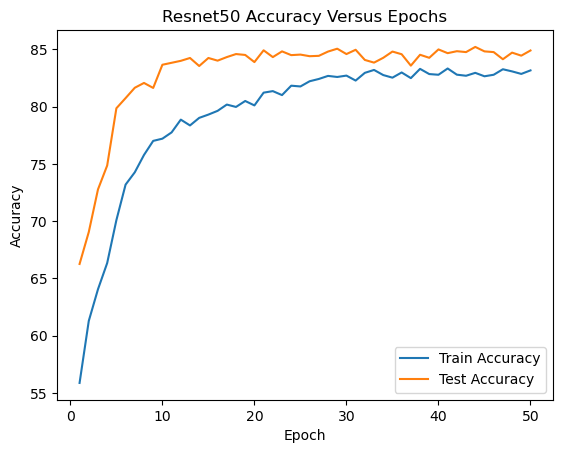

In [23]:
plt.plot(np.arange(1,len(train_accuracy)+1),train_accuracy,label='Train Accuracy')
plt.plot(np.arange(1,len(test_accuracy)+1),test_accuracy,label='Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Resnet50 Accuracy Versus Epochs')
plt.show()

In [ ]:
nb_classes = 5

confusion_matrix = torch.zeros(nb_classes, nb_classes)
model.eval()
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        #print(classes)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

/tmp/ipykernel_19462/3367771019.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = self.softmax(out)


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm/ np.sum(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2%' #if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
plt.figure()
num_classes=5
M = confusion_matrix.numpy()
plot_confusion_matrix(M, classes=np.arange(num_classes), 
                      normalize=True,title="Resnet50 Confusion Matrix")
print("Accuracy:",np.trace(M/np.sum(M)))

###### 